In [3]:
import torch
from visualise import visualise_v_quiver
import matplotlib.pyplot as plt

from utils import make_grid

# Simulation of detailed divergence-free fields via the stream function/Lagrange function

- Also refer to [Wikipedia's stream function entry for more details](https://en.wikipedia.org/wiki/Stream_function)
- A stream function defines 2D scalar field. The curl of this scalar field yields a divergence-free (i.e. solenoidal) vector field. This vector field can be interpreted as a flow along the contours of scalar field, i.e. orthogonal to the gradient of the vector field. These contours are also referred to as streamlines. We exploit this relationship to simulate divergence-free fields for our experiments. 
- We compose stream fields of 
    - An basline stream field (BS) for the large-scale stream
    - An unnormalised Gaussian Mixture (UGM) to add detail

ToDo:
- check if we need to use Jacobians or if we can speed it up with just autograd

In [6]:
# define grid resolution
N_SIDE = 2**7 # 128

# use function defined in utils.py to create a grid
x_grid, x_long = make_grid(n_side = N_SIDE)

# Functions

- make a Gaussian mixture
- combine underlying stream and and Gaussian Mixture
- Generate divergence-free vector field
- 4 plots: GM, US, combined, vector field

In [98]:
def get_pdf_of_gaussian_component(x_grid, mu, sigma):
    """ Caluclate the probability density function (pdf) of a 2D Gaussian component at each point in the grid.
    p(x) = (1 / (2 * π * sqrt(det(Σ)))) * exp(-0.5 * (x - μ)ᵀ Σ⁻¹ (x - μ))

    Args:
        x_grid (torch.Size([n_side, n_side, 2])): x coordinate grid where the last two dims are the x and y coordinates
        mu (torch.Size([2])): mean location of the Gaussian component, should be within x_grid domain of course
        sigma (torch.Size([2, 2])): Covariance matrix of the Gaussian component

    Returns:
        pdf_grid (torch.Size([n_side, n_side])): pdf of the Gaussian component at each point in the grid
    """
    x_grid_flat = x_grid.view(-1, 2) # shape: (n_side**2, 2)
    diff = x_grid_flat - mu # shape: (n_side**2, 2)

    inv_sigma = torch.linalg.inv(sigma) # shape: (2, 2) - invert so we can multiply
    det_sigma = torch.linalg.det(sigma) # shape: (1,) - determinant is a scalar

    # Mahalanobis distance: (x - μ)ᵀ Σ⁻¹ (x - μ), for each x in the grid
    # Step 1: Matmul to get the intermediate result (N, D) @ (D, D) → (N, D)
    # Step 2: Mul is element-wise multiplication
    # Step 3: Sum over the last dimension to get the final result (N, D) → (N, 1)
    exponent = -0.5 * torch.sum(torch.mul(torch.matmul(diff, inv_sigma), diff), dim = 1)

    # sqrt(det(Σ)) is the square root of the determinant of the covariance matrix Σ.
    norm_multiplier = 1 / (2 * torch.pi * torch.sqrt(det_sigma))

    # Put it all together
    pdf_grid_flat = norm_multiplier * torch.exp(exponent) # shape: (n_side**2, 1)
    # Reshape to (n_side, n_side) i.e. grid
    pdf_grid = pdf_grid_flat.view(N_SIDE, N_SIDE) # shape: (n_side, n_side)

    return pdf_grid

def compose_unnormalised_gaussian_mixture(x_grid, mus, sigmas, weights):
    """ Compose an unnormalised Gaussian mixture (UGM) from multiple Gaussian components.

    Args:
        x_grid (torch.Size([n_side, n_side, 2])): x coordinate grid where the last two dims are the x and y coordinates
        mus (list of torch.Size([2])): list of mean locations of the Gaussian components
        sigmas (list of torch.Size([2, 2])): list of covariance matrices of the Gaussian components
        weights (list of float): list of weights for each Gaussian component

    Returns:
        pdf_grid (torch.Size([n_side, n_side])): pdf of the UGM at each point in the grid
    """
    # Extract grid size for intialisation of placeholder
    n_side = x_grid.shape[0] 

    # Unnormalised Gaussian Mixture Model (UGM) is a weighted sum of the individual Gaussian components
    ugm_grid = torch.zeros(n_side, n_side) # shape: (n_side, n_side)

    for mu, sigma, weight in zip(mus, sigmas, weights):
        ugm_grid += weight * get_pdf_of_gaussian_component(x_grid, mu, sigma)

    return ugm_grid

def get_directed_bls(x_grid, angle_degree):
    """
    Generate a linear stream function (scalar field) based on the x coordinate grid.
    The stream function is directed in a specified angle (in degrees).
    Args:
        x_grid (torch.Size([n_side, n_side, 2])): x coordinate grid where the last two dims are the x and y coordinates
        angle_degree (float): angle in degrees for the direction of the stream function
    Returns:
        directed_stream (torch.Size([n_side, n_side])): directed stream function at each point in the grid
    """
    # Convert the angle from degrees to radians
    angle_rad = torch.deg2rad(torch.tensor(angle_degree))

    a = torch.cos(angle_rad)  # x weight
    b = torch.sin(angle_rad)  # y weight

    # stream(x, y) = a * x + b * y
    directed_stream = a * x_grid[:, :, 0] + b * x_grid[:, :, 1] # shape: (n_side, n_side)
    
    return directed_stream

def combine_bls_and_ugm(bls_grid, ugm_grid, ugm_weight = 1.0):
    """ Combine the BLS and UGM grids to get the final grid. Both grids are assumed to be the same size.

    Args:
        bls_grid (torch.Size([n_side, n_side])): BLS grid
        ugm_grid (torch.Size([n_side, n_side])): UGM grid

    Returns:
        combined_grid (torch.Size([n_side, n_side])): combined grid
    """
    # Combine the BLS and UGM grids
    combined_grid = bls_grid + (ugm_weight * ugm_grid)

    return combined_grid

def get_vector_field_from_stream(x_grid, psi_grid):
    """ We use autograd to calculate the partial derivatives of the stream function and then compose the curl, i.e. the divergence-free vector field from it. 

    Note: 
    - Computing the full Jacobian is not necessary ("Jacobian overkill"), since we only need the partial derivatives of the stream function with respect to x and y. 
    - While at first glance it appears suprising that we can use the psi.sum() function to get a scalar output, this is because the gradient of a scalar function with respect to a vector is a vector, and psi[i, j] only depends on x[i, j], so the gradient is non-zero only for the i, j-th element of the x tensor.

    This would yield the same result as:
    grad_psi = torch.autograd.grad(
        outputs = psi, # non-scalar output
        inputs = x_grid,
        grad_outputs = torch.ones_like(psi)) 

    More background is provided here: https://discuss.pytorch.org/t/need-help-computing-gradient-of-the-output-with-respect-to-the-input/150950/4

    Alternative: torch.gradient() is based on finite differences, so it is not a perfect gradient operator.

    Args:
        x_grid (torch.Size([n_side, n_side, 2])): x coordinate grid where the last two dims are the x and y coordinates. Must have had requires_grad = True!!
        psi_grid (torch.Size([n_side, n_side])): psi stream function grid generated from x_grid

    Returns:
        vector_field (torch.Size([n_side, n_side, 2])): vector field at each point in the grid
    """
    grad_psi = torch.autograd.grad(
        outputs = psi_grid.sum(), # scalar, but only depends on corresponding x[i, j]
        inputs = x_grid, 
        )[0] # index 0 because we only have one input tensor

    # Calculate the vector field (curl) from the gradients: dψ/dy and -dψ/dx
    vector_field = torch.stack([grad_psi[:, :, 1], - grad_psi[:, :, 0]], dim = -1) # shape: (n_side, n_side, 2)

    return vector_field

## Define all inputs

In [99]:
list_of_mus = [
    torch.tensor([0.3, 0.3]),
    torch.tensor([0.98, 0.7]),
    torch.tensor([0.3, 0.98])
    ]

# Covariance matrices for each Gaussian component
# Smaller: Lower variance (more concentrated) in that direction
# Off-diagonal elements: Correlation between x and y
list_of_sigmas = [
    torch.tensor([[0.05, 0.0], [0.0, 0.05]]),
    torch.tensor([[0.08, 0.0], [0.0, 0.05]]),
    torch.tensor([[0.2, 0.0], [0.0, 0.02]])
    ]

list_of_weights = [
    -0.1, 0.40, 0.20
    ] 

bsl_angle = 45
solid_ugm_weight = 0.5

In [100]:
x_grid = x_grid.requires_grad_() # Set requires_grad to True for gradients i.e. to calculate the curl

ugm = compose_unnormalised_gaussian_mixture(
    x_grid,
    list_of_mus,
    list_of_sigmas,
    list_of_weights
)

bls = get_directed_bls(x_grid, angle_degree = bsl_angle)

# stream function
psi = combine_bls_and_ugm(bls, ugm, ugm_weight = solid_ugm_weight)

vector_field = get_vector_field_from_stream(x_grid, psi)

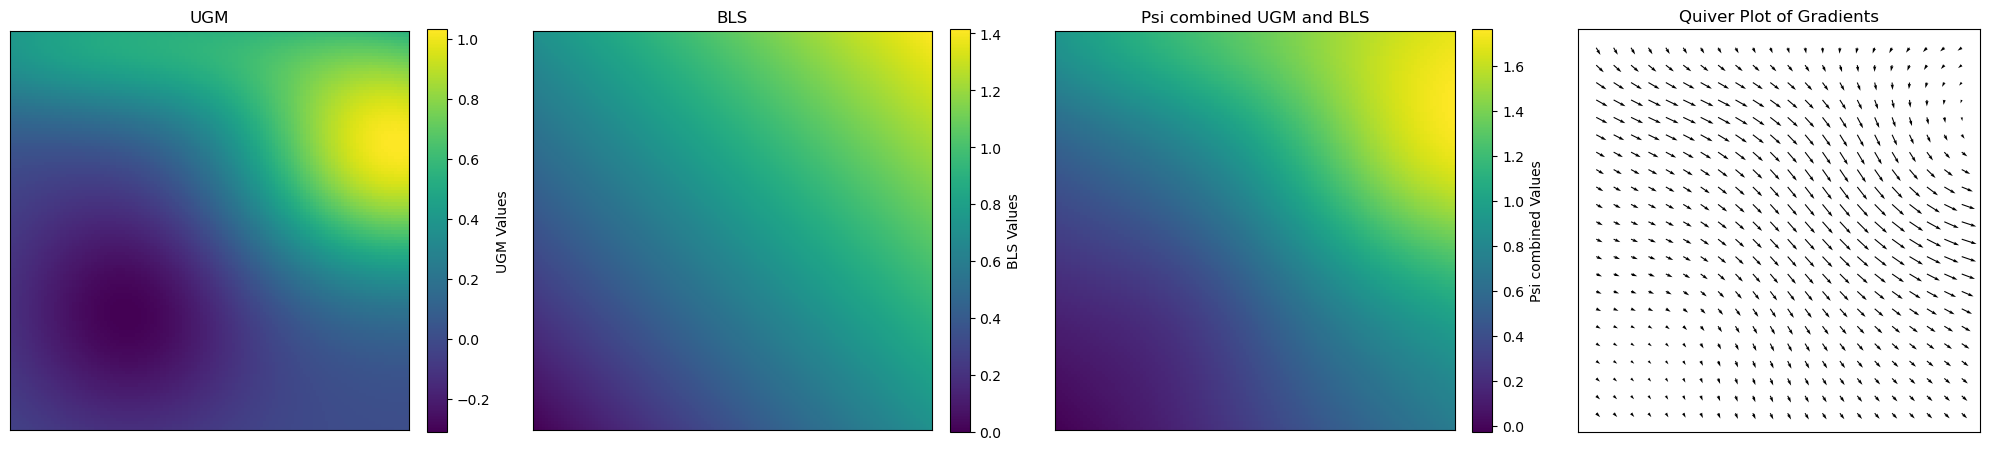

In [107]:
fig, ax = plt.subplots(1, 4, figsize = (20, 5), gridspec_kw = {'width_ratios': [1, 1, 1, 0.92]}) 

# Plot UGM (Unnormalized Gaussian Mixture)
c1 = ax[0].pcolormesh(ugm.detach(), cmap = 'viridis', shading = 'auto')
cbar1 = fig.colorbar(c1, ax = ax[0], label = 'UGM Values', fraction = 0.046, pad = 0.04)  # fraction and pad sligns the height
ax[0].set_title('UGM')
ax[0].set_aspect('equal')

# Plot BLS (Directed Bed Load Sediment Flux)
c2 = ax[1].pcolormesh(bls.detach(), cmap = 'viridis', shading = 'auto')
cbar2 = fig.colorbar(c2, ax = ax[1], label = 'BLS Values', fraction = 0.046, pad = 0.04)
ax[1].set_title('BLS')
ax[1].set_aspect('equal')

# Plot Combined (UGM + BLS)
c3 = ax[2].pcolormesh(psi.detach(), cmap = 'viridis', shading = 'auto')
cbar3 = fig.colorbar(c3, ax = ax[2], label = 'Psi combined Values', fraction = 0.046, pad = 0.04) 
ax[2].set_title('Psi combined UGM and BLS')
ax[2].set_aspect('equal')

# Plot Quiver (Velocity Field)
step = 6 # subsample

ax[3].quiver(
    x_grid[::step, ::step, 0].detach(),  # x coordinates, subsampled
    x_grid[::step, ::step, 1].detach(),  # y coordinates, subsampled
    vector_field[::step, ::step, 0].detach(),  # u component of the field, subsampled
    vector_field[::step, ::step, 1].detach(),  # v component of the field, subsampled
    color = 'black',
)
ax[3].set_title('Quiver Plot of Gradients')
ax[3].set_aspect('equal')


# Remove ticks for all axes in the figure
for a in ax:
    a.set_xticks([])  # Remove x-axis ticks
    a.set_yticks([])  # Remove y-axis ticks

# Adjust layout to avoid overlap and ensure colorbars are same height
plt.tight_layout()

# Optional: You can adjust the space between subplots and colorbars
plt.subplots_adjust(wspace = 0.2)  # Adjust horizontal space between plots

# Show the plot
plt.show()

# Old

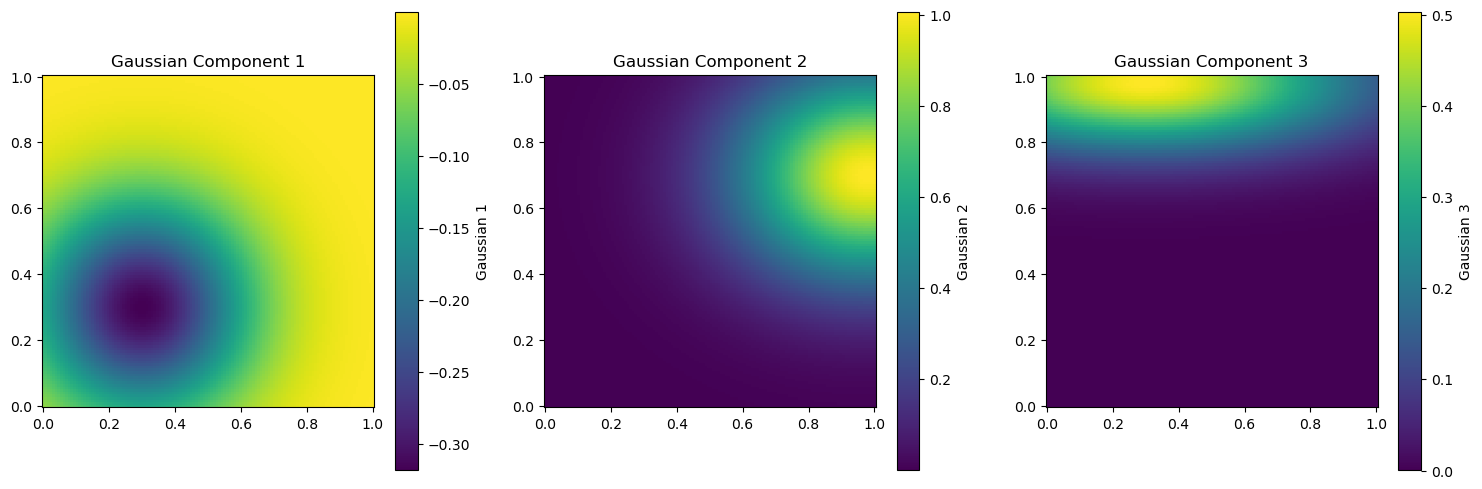

In [ ]:
# Step 3: Define mixture components
# Where is the centre point of the Gaussian mixture component
means = [
    torch.tensor([0.3, 0.3]),
    torch.tensor([0.98, 0.7]),
    torch.tensor([0.3, 0.98])
]

# Covariance matrices for each Gaussian component
# Smaller: Lower variance (more concentrated) in that direction
# Off-diagonal elements: Correlation between x and y
covs = [
    torch.tensor([[0.05, 0.0], [0.0, 0.05]]),
    torch.tensor([[0.08, 0.0], [0.0, 0.05]]),
    torch.tensor([[0.2, 0.0], [0.0, 0.02]])
]

weights = [-0.1, 0.40, 0.20]  # Weights are not used for individual Gaussian outputs now

# Simulate the Gaussian mixture field but return each Gaussian individually
def simulate_individual_gaussians(x_grid):
    gaussian_fields = []
    for mu, cov in zip(means, covs):
        # Compute the individual Gaussian component
        gaussian_field = single_2d_gaussian(x_grid, mu, cov)
        gaussian_fields.append(gaussian_field)
    return gaussian_fields

gaussian_fields = simulate_individual_gaussians(x_grid)

# Plot the individual Gaussian components
fig, axes = plt.subplots(1, len(means), figsize = (15, 5), dpi = 100)

for i, gaussian_field in enumerate(gaussian_fields):
    im = axes[i].pcolormesh(x_grid[:, :, 0], x_grid[:, :, 1], gaussian_field * weights[i], shading='auto', cmap='viridis')
    fig.colorbar(im, ax = axes[i], label= f'Gaussian {i+1}')
    axes[i].set_title(f"Gaussian Component {i+1}")
    axes[i].set_aspect('equal')

plt.tight_layout()
plt.show()

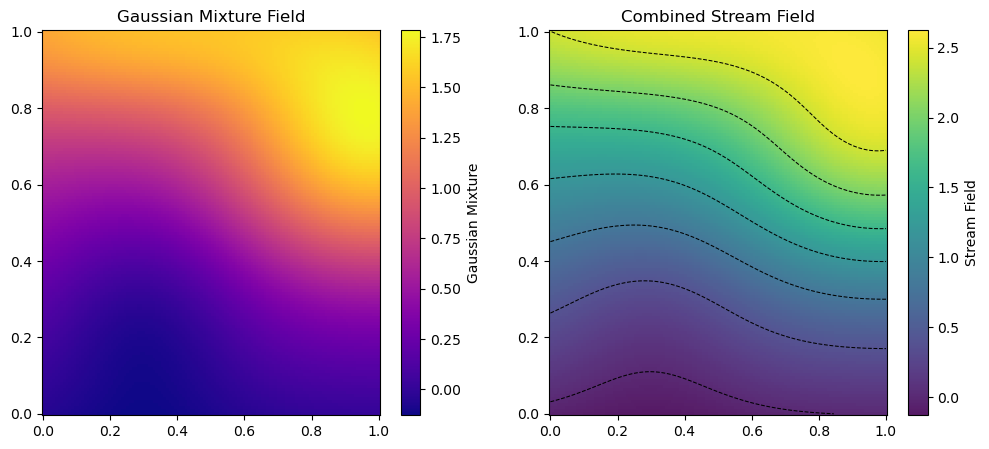

In [ ]:
def simulate_streamfunction_andgm(x_grid, weights = weights, means = means, covs = covs):
    underlying_stream = 1.0 * x_grid[:, :, -1]

    gaussian_mixture_field = underlying_stream.clone()

    for w, mu, cov in zip(weights, means, covs):
        # Compute the individual Gaussian component
        gaussian_mixture_field += single_2d_gaussian(x_grid, mu, cov) * w

    # Add Gaussian mixture field (adding and subtracting in places)
    stream_field = underlying_stream + gaussian_mixture_field

    return stream_field, gaussian_mixture_field

def simulate_streamfunction(x_grid, weights = weights, means = means, covs = covs):
    underlying_stream = 1.0 * x_grid[:, :, -1]

    gaussian_mixture_field = underlying_stream.clone()

    for w, mu, cov in zip(weights, means, covs):
        # Compute the individual Gaussian component
        gaussian_mixture_field += single_2d_gaussian(x_grid, mu, cov) * w

    # Add Gaussian mixture field (adding and subtracting in places)
    stream_field = underlying_stream + gaussian_mixture_field

    return stream_field

def plot_streamfunction(x_grid, stream_field, gaussian_mixture_field):
    fig, axes = plt.subplots(1, 2, figsize = (12, 5), dpi = 100)

     # Left: Gaussian Mixture Field
    im0 = axes[0].pcolormesh(
        x_grid[:, :, 0], x_grid[:, :, 1], gaussian_mixture_field,
        shading = 'auto', cmap = 'plasma')
    fig.colorbar(im0, ax = axes[0], label = 'Gaussian Mixture')
    axes[0].set_title("Gaussian Mixture Field")

    # Right: Stream Field (base + mixture)
    im1 = axes[1].pcolormesh(
        x_grid[:, :, 0], x_grid[:, :, 1], stream_field,
        shading='auto', cmap='viridis', alpha=0.9)
    fig.colorbar(im1, ax = axes[1], label = 'Stream Field')
    axes[1].contour(
        x_grid[:, :, 0], x_grid[:, :, 1], stream_field,
        colors = 'k', linestyles = '--', linewidths = 0.75)
    axes[1].set_title("Combined Stream Field")

stream_field, gaussian_mixture_field = simulate_streamfunction_andgm(x_grid)
plot_streamfunction(x_grid, stream_field, gaussian_mixture_field)

In [50]:
grad_psi = torch.autograd.grad(
    outputs = combined_stream,
    inputs = x_test_grid,
    grad_outputs = torch.ones_like(combined_stream) # non scalar setting: equal contributions from each output element
    )[0]  # shape: (n_side, n_side, 2)

# Now form the velocity field via curl:
u = grad_psi[:, :, 1]
v = - grad_psi[:, :, 0]

velocity = torch.stack([u, v], dim = -1)  # shape: (n_side, n_side, 2)

# Old

In [79]:
def simulate_streamfunction_from_bed(x_test_grid):

    # Base linear stream function giving uniform flow in ~250° direction
    angle_deg = 170
    angle_rad = torch.deg2rad(torch.tensor(angle_deg, dtype = torch.float32))

    a = torch.cos(angle_rad)  # x-weight
    b = torch.sin(angle_rad)  # y-weight

    # ψ(x, y) = a*x + b*y (gives uniform flow in direction orthogonal to gradient)
    underlying_stream = a * x_test_grid[:, :, 0] + b * x_test_grid[:, :, 1]

    # Add Gaussian mixture field (adding and subtracting in places)
    # bed is a scalar
    stream_field = underlying_stream + 0.05 * bed_selection_norm.requires_grad_(True)

    return stream_field

torch.autograd is designed to compute gradients with respect to a scalar value: torch.Size([])

In [104]:
import torch
import torch.nn.functional as F

def simulate_streamfunction_from_bed(x_test_grid, bed_field):
    """
    x_test_grid: [H, W, 2] – spatial (x, y) coordinates
    bed_field: [H, W] – the 2D scalar field input you want gradients w.r.t.
    """

    angle_deg = 170
    angle_rad = torch.deg2rad(torch.tensor(angle_deg, dtype=torch.float32))

    a = torch.cos(angle_rad)
    b = torch.sin(angle_rad)

    # Linear flow component
    underlying_stream = a * x_test_grid[:, :, 0] + b * x_test_grid[:, :, 1]

    # Add bed effect directly — now it's a differentiable input
    stream_field = underlying_stream + 0.5 * bed_field

    return stream_field

In [ ]:
x_grid = x_test_grid_tensor.clone().detach()       # shape: [H, W, 2]
bed_field = bed_selection_norm.clone().detach().requires_grad_(True)  # shape: [H, W]

stream = simulate_streamfunction_from_bed(x_grid, bed_field)  # shape: [H, W]
grad_bed = torch.autograd.grad(stream.sum(), bed_field, create_graph = True)[0]  # shape: [H, W]

In [ ]:
# Assuming bed_field is your scalar field representing the bed topography (e.g., shape: [H, W])
bed_field = bed_selection_norm.clone().detach().requires_grad_(True)  # shape: [H, W]

# Assume x_test_grid is your grid with spatial coordinates, with shape [H, W, 2]
x_test_grid = x_test_grid_tensor.clone().detach()

# Now calculate the gradient of bed_field w.r.t. the spatial coordinates
grad_bed = torch.autograd.grad(bed_field, x_test_grid, create_graph=True)[0]

RuntimeError: grad can be implicitly created only for scalar outputs

In [98]:
bed_field.shape

torch.Size([150, 150])

In [80]:
x = x_test_grid_tensor.clone().detach().requires_grad_(True)
output = simulate_streamfunction_from_bed(x)  # shape: [H, W]
grad = torch.autograd.grad(output.sum(), x, create_graph = True)[0]

In [81]:
grad

tensor([[[-0.9848,  0.1736],
         [-0.9848,  0.1736],
         [-0.9848,  0.1736],
         ...,
         [-0.9848,  0.1736],
         [-0.9848,  0.1736],
         [-0.9848,  0.1736]],

        [[-0.9848,  0.1736],
         [-0.9848,  0.1736],
         [-0.9848,  0.1736],
         ...,
         [-0.9848,  0.1736],
         [-0.9848,  0.1736],
         [-0.9848,  0.1736]],

        [[-0.9848,  0.1736],
         [-0.9848,  0.1736],
         [-0.9848,  0.1736],
         ...,
         [-0.9848,  0.1736],
         [-0.9848,  0.1736],
         [-0.9848,  0.1736]],

        ...,

        [[-0.9848,  0.1736],
         [-0.9848,  0.1736],
         [-0.9848,  0.1736],
         ...,
         [-0.9848,  0.1736],
         [-0.9848,  0.1736],
         [-0.9848,  0.1736]],

        [[-0.9848,  0.1736],
         [-0.9848,  0.1736],
         [-0.9848,  0.1736],
         ...,
         [-0.9848,  0.1736],
         [-0.9848,  0.1736],
         [-0.9848,  0.1736]],

        [[-0.9848,  0.1736],
       

In [44]:
x = x_test_grid.clone().detach().requires_grad_(True)
output = simulate_streamfunction_from_bed(x)  # scalar
grad = torch.autograd.grad(output, x, create_graph = True)[0]

RuntimeError: grad can be implicitly created only for scalar outputs

In [102]:
n_side = bed_selection_norm.shape[0]

side_array = torch.linspace(start = 0.0, end = 1.0, steps = n_side)
XX, YY = torch.meshgrid(side_array, side_array, indexing = "xy")
x_test_grid = torch.cat([XX.unsqueeze(-1), YY.unsqueeze(-1)], dim = -1)
# long format
x_test = x_test_grid.reshape(-1, 2)

def simulate_streamfunction_from_bed_grad(x_test_grid, bed = bed_selection_norm):

    # Base linear stream function giving uniform flow in ~250° direction
    angle_deg = 350
    angle_rad = torch.deg2rad(torch.tensor(angle_deg, dtype = torch.float32))

    a = torch.cos(angle_rad)  # x-weight
    b = torch.sin(angle_rad)  # y-weight

    # ψ(x, y) = a*x + b*y (gives uniform flow in direction orthogonal to gradient)
    underlying_stream = a * x_test_grid[:, :, 0] + b * x_test_grid[:, :, 1]

    # Add Gaussian mixture field (adding and subtracting in places)
    # bed is a scalar
    # Make sure bed_selection_norm requires grad
    if not bed.requires_grad:
        bed = bed.clone().detach().requires_grad_()
        
    stream_field = underlying_stream + 0.5 * bed # bed fixed
    
    # plt.imshow(stream_field, cmap = 'viridis', origin = 'lower')

    return stream_field

torch.Size([150, 150, 2])


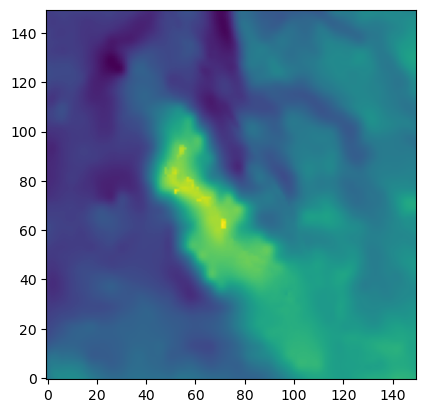

In [103]:
n_side = bed_selection_norm.shape[0]

side_array = torch.linspace(start = 0.0, end = 1.0, steps = n_side)
XX, YY = torch.meshgrid(side_array, side_array, indexing = "xy")
x_test_grid = torch.cat([XX.unsqueeze(-1), YY.unsqueeze(-1)], dim = -1)
# long format
x_test = x_test_grid.reshape(-1, 2)

print(x_test_grid.shape)
stream = simulate_streamfunction_from_bed_grad(x_test_grid)

plt.imshow(stream.detach(), cmap = 'viridis', origin = 'lower')

In [ ]:
F.avg_pool2d(field.unsqueeze(0).unsqueeze(0), kernel_size=3, stride=1, padding=1)[0, 0]

# run for bed 

In [106]:
# x_test_grid: shape (N, 2)
x_test_grid_tensor = torch.tensor(x_test_grid, dtype = torch.float32, requires_grad = True)

# Compute the streamfunction values
psi = simulate_streamfunction_from_bed(x_test_grid_tensor, bed_selection_norm)  # shape: (N,) or (N, 1)

# Compute gradient of psi w.r.t. inputs (x, y)
grad_psi = torch.autograd.grad(
    outputs = psi,
    inputs = x_test_grid_tensor,
    grad_outputs = torch.ones_like(psi),
    create_graph = True,
    retain_graph = True,
    allow_unused = True
)[0]  # shape: (N, 2)

# grad_psi[:, 0] = ∂ψ/∂x, grad_psi[:, 1] = ∂ψ/∂y

# grad_psi is a tensor of shape torch.Size([200, 200, 2])
# Now form the velocity field via curl:
u = grad_psi[:, :, 1]              # ∂ψ/∂y
v = - grad_psi[:, :, 0]             # -∂ψ/∂x

velocity = torch.stack([u, v], dim = -1)  # shape: (N, 2)

/tmp/ipykernel_1081134/194400316.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_grid_tensor = torch.tensor(x_test_grid, dtype = torch.float32, requires_grad = True)


In [111]:
# x_test_grid: shape (N, 2)
x_test_grid_tensor = torch.tensor(x_test_grid, dtype = torch.float32, requires_grad = True)

# Compute the streamfunction values
psi = simulate_streamfunction_from_bed(x_test_grid_tensor, bed_selection_norm)  # shape: (N,) or (N, 1)

# Compute gradient of psi w.r.t. inputs (x, y)
grad_psi = torch.autograd.grad(
    outputs = psi,
    inputs = bed_selection_norm,
    grad_outputs = torch.ones_like(psi),
    create_graph = True,
    retain_graph = True,
    allow_unused = True
)[0]  # shape: (N, 2)

# grad_psi[:, 0] = ∂ψ/∂x, grad_psi[:, 1] = ∂ψ/∂y

# grad_psi is a tensor of shape torch.Size([200, 200, 2])
# Now form the velocity field via curl:
u = grad_psi[:, :, 1]              # ∂ψ/∂y
v = - grad_psi[:, :, 0]             # -∂ψ/∂x

velocity = torch.stack([u, v], dim = -1)  # shape: (N, 2)

/tmp/ipykernel_1081134/787238577.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_grid_tensor = torch.tensor(x_test_grid, dtype = torch.float32, requires_grad = True)


IndexError: too many indices for tensor of dimension 2

In [ ]:
import torch
import torch.nn.functional as F

# 1. Define bed field
H, W = 150, 150  # height and width of the spatial grid
# bed_selection_norm = torch.randn(H, W)  # your 2D scalar field

# 2. Create x_grid of shape [H, W, 2] with spatial coordinates
x = torch.linspace(0, W - 1, W)
y = torch.linspace(0, H - 1, H)
xv, yv = torch.meshgrid(x, y, indexing='xy')  # xv, yv: [H, W]

x_grid = torch.stack((xv, yv), dim=-1)  # shape: [H, W, 2]
x_grid = x_grid.clone().detach().requires_grad_(True)  # make differentiable

# 3. Normalize x_grid to [-1, 1] for grid_sample
x_norm = 2 * (x_grid[..., 0] / (W - 1) - 0.5)
y_norm = 2 * (x_grid[..., 1] / (H - 1) - 0.5)
grid = torch.stack((x_norm, y_norm), dim=-1).unsqueeze(0).to(torch.float32)  # shape: [1, H, W, 2]

# 4. Sample the bed field at the coordinates
bed_tensor = bed_selection_norm.unsqueeze(0).unsqueeze(0).to(torch.float32)  # shape: [1, 1, H, W]
bed_sampled = F.grid_sample(bed_tensor, grid, align_corners=True, mode='bilinear')[0, 0]  # shape: [H, W]

# 5. Compute gradients w.r.t. x_grid
grad = torch.autograd.grad(bed_sampled.sum(), x_grid, create_graph=True)[0]  # shape: [H, W, 2]


# grad[..., 0] is ∂bed/∂x, grad[..., 1] is ∂bed/∂y

In [136]:
import torch
import torch.nn.functional as F

def gaussian_smooth_2d(field, kernel_size=5, sigma=1.0):
    """Apply Gaussian blur to a 2D tensor."""
    # Create 1D Gaussian kernel
    def get_gaussian_kernel1d(kernel_size, sigma):
        coords = torch.arange(kernel_size) - kernel_size // 2
        kernel = torch.exp(-(coords**2) / (2 * sigma**2))
        kernel = kernel / kernel.sum()
        return kernel

    # Make 2D separable Gaussian kernel
    kernel1d = get_gaussian_kernel1d(kernel_size, sigma)
    kernel2d = torch.outer(kernel1d, kernel1d)
    kernel2d = kernel2d.unsqueeze(0).unsqueeze(0)  # shape: [1, 1, k, k]

    # Pad and apply filter
    field = field.unsqueeze(0).unsqueeze(0)  # [1, 1, H, W]
    padding = kernel_size // 2
    smoothed = F.conv2d(field, kernel2d, padding=padding)
    return smoothed[0, 0]  # back to [H, W]

# Usage
smoothed_bed = gaussian_smooth_2d(bed_selection_norm.to(torch.float32), kernel_size=5, sigma=1.0)


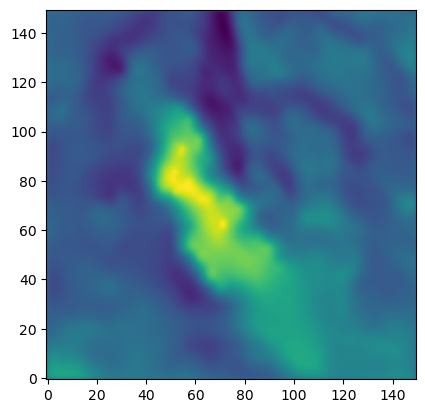

In [137]:
bed_sampled.shape
plt.imshow(smoothed_bed.detach(), cmap = 'viridis', origin = 'lower')

In [22]:
jac = torch.autograd.functional.jacobian(simulate_streamfunction_from_bed_grad, x_test_grid_tensor)

In [99]:
jac.shape

torch.Size([150, 150, 150, 150, 2])

In [108]:
psi

tensor([[ 0.5231,  0.5972,  0.6592,  ..., -0.5679, -0.5976, -0.6289],
        [ 0.5444,  0.6193,  0.6771,  ..., -0.5845, -0.6178, -0.6531],
        [ 0.5511,  0.6245,  0.6800,  ..., -0.6101, -0.6476, -0.6894],
        ...,
        [ 0.0828,  0.0757,  0.0703,  ..., -0.7998, -0.8063, -0.8133],
        [ 0.0891,  0.0848,  0.0811,  ..., -0.8404, -0.8476, -0.8534],
        [ 0.0995,  0.0941,  0.0876,  ..., -0.8811, -0.8908, -0.8949]],
       dtype=torch.float64, grad_fn=<AddBackward0>)

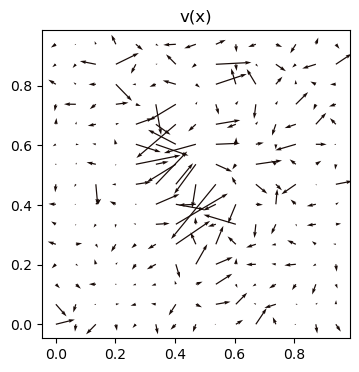

In [134]:
step = 10
visualise_v_quiver(
    grad[::step, ::step, :].reshape(-1, 2),
    x_test_grid[::step, ::step, :].reshape(-1, 2))

In [70]:
# x_test_grid: shape (N, 2)
x_test_grid_tensor = torch.tensor(x_test_grid, dtype = torch.float32, requires_grad = True)

# Compute the streamfunction values
psi = simulate_streamfunction(x_test_grid_tensor)  # shape: (N,) or (N, 1)

# Compute gradient of psi w.r.t. inputs (x, y)
grad_psi = torch.autograd.grad(
    outputs = psi,
    inputs = x_test_grid_tensor,
    grad_outputs = torch.ones_like(psi),
    create_graph = True,
    retain_graph = True,
    allow_unused = True
)[0]  # shape: (N, 2)

# grad_psi[:, 0] = ∂ψ/∂x, grad_psi[:, 1] = ∂ψ/∂y

# grad_psi is a tensor of shape torch.Size([200, 200, 2])
# Now form the velocity field via curl:
u = grad_psi[:, :, 1]              # ∂ψ/∂y
v = - grad_psi[:, :, 0]             # -∂ψ/∂x

velocity = torch.stack([u, v], dim = -1)  # shape: (N, 2)

/tmp/ipykernel_488413/2306907230.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_grid_tensor = torch.tensor(x_test_grid, dtype = torch.float32, requires_grad = True)


In [ ]:
slicer = slice(33, None, 67)
velocity[:, :, 0]

torch.Size([3, 200])

RuntimeError: shape '[200, 200]' is invalid for input of size 22500

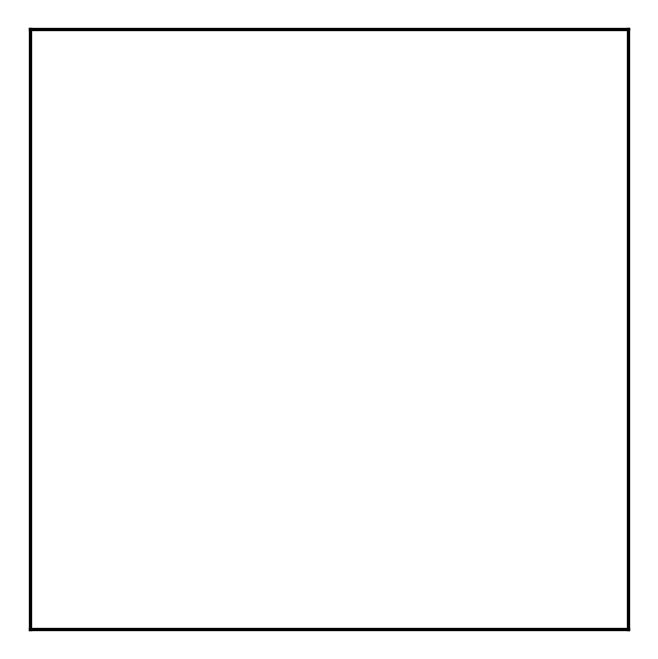

In [163]:
fig = plt.figure(figsize = (2,4), dpi = 300)

ax = plt.axes((0, 0.5, 0.997, 0.5))
ax.set_xticks([])
ax.set_yticks([])
step = 10 # downsample

plt.quiver(x_test[:, 0].reshape(N_SIDE, N_SIDE)[::step, ::step], 
           x_test[:, 1].reshape(N_SIDE, N_SIDE)[::step, ::step], 
           velocity[:, :, 0].detach()[::step, ::step], 
           velocity[:, :, 1].detach()[::step, ::step], 
           color = 'red')

plt.contour(x_test[:, 0].reshape(N_SIDE, N_SIDE),
            x_test[:, 1].reshape(N_SIDE, N_SIDE), 
            psi.detach(), 
            colors = 'k', 
            linewidths = 0.15)


# 3D plot
ax = fig.add_axes((0, 0, 1, 0.5), projection = '3d', computed_zorder = False)
ax.view_init(30, -60, 0)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.plot_surface(x_test[:, 0].reshape(N_SIDE, N_SIDE), x_test[:, 1].reshape(N_SIDE, N_SIDE), 
                psi.detach(), cmap = 'RdYlGn', linewidth = 0, antialiased = False)
ax.contour(x_test[:, 0].reshape(N_SIDE, N_SIDE), x_test[:, 1].reshape(N_SIDE, N_SIDE), 
           psi.detach(), colors='k', linestyles = '--', linewidths = 0.5, zorder = 1000)
plt.show()

# Scalar fields to construct quiver plots

- A cone scalar field gives a full swirl.
- The stream function is a scalar field whose gradient gives the velocity field.


In 2D, any smooth, divergence-free vector field q(x,y) can be written as the rotated gradient of a scalar function ψ(x,y), often called the stream function.

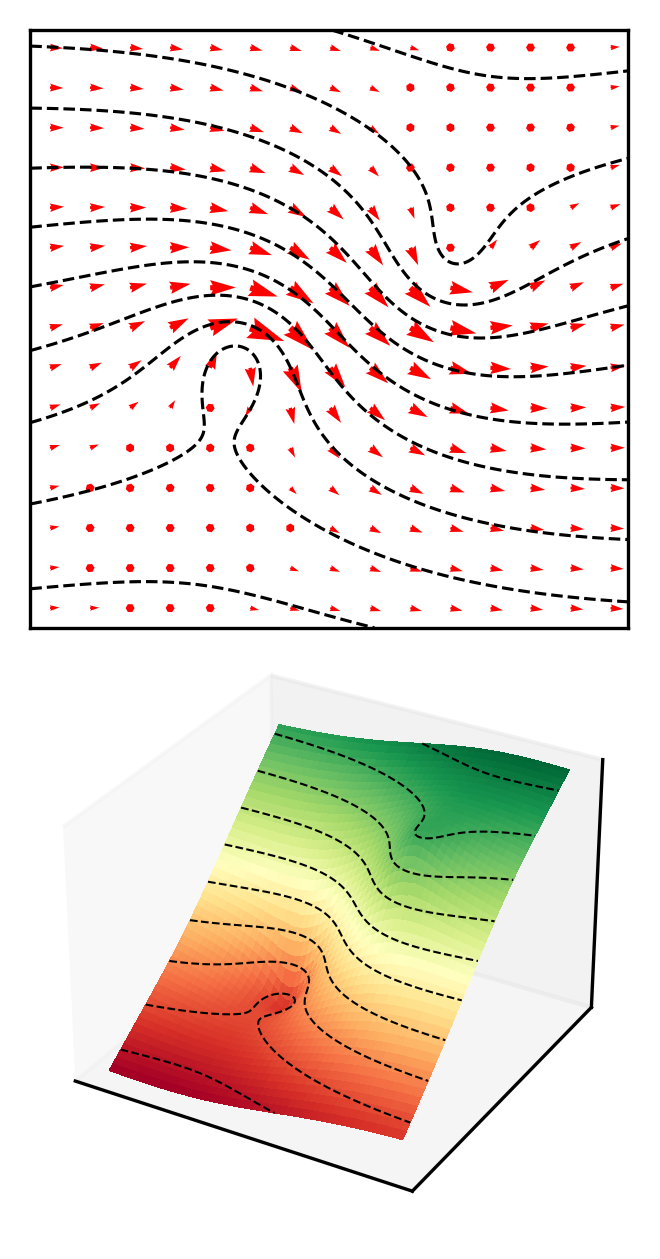

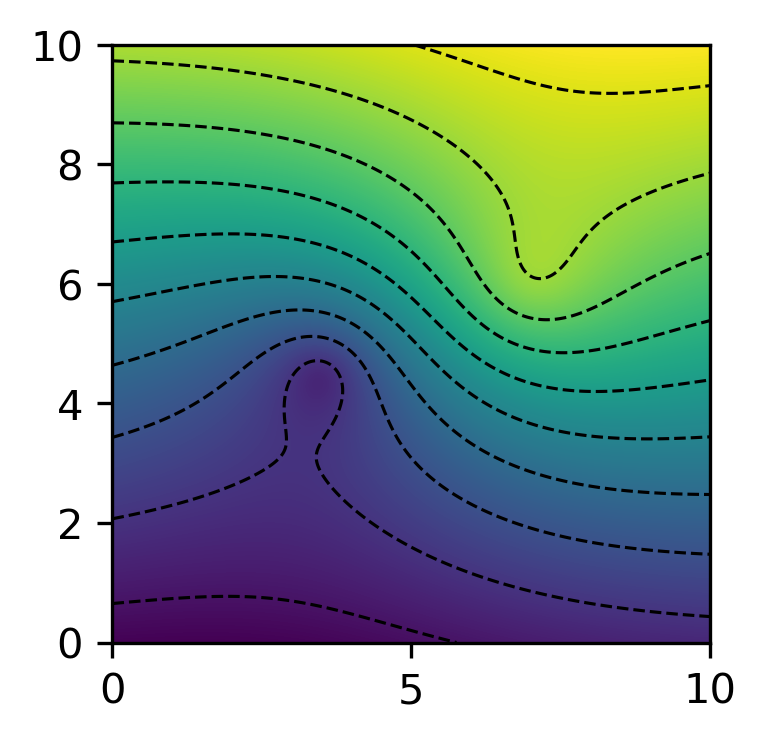

In [77]:
import numpy as np

# make a 1001 x 1001 grid
x = np.linspace(0, 10, 1001)
y = np.linspace(0, 10, 1001)[:, None] # extra dim

dx = x[1] - x[0] # step size 0.01 
dy = y[1, 0] - y[0, 0] # step size 0.01 

# if x are the grid points at the centroids of the cells, then
# the grid points are at the edges of the cells
extent = (x[0] - 0.5*dx, x[-1] + 0.5*dx, y[0,0] - 0.5*dy, y[-1,0] + 0.5*dy)

# Vortex
def vort(x0, y0, r):
	return - np.log(np.sqrt((x - x0)**2 + (y - y0)**2 + r**2))

# construct some stream function with
# overall background flow in x direction (right): 0 to 1.5
streamfunc = 0 * x + 0.15 * y
# put an irrotational vortex (singular) with negative vorticity, r is radius
streamfunc -= 0.30 * vort(3.5, 4.5, 0.5)
# make a spread-out vortex with positive vorticity
streamfunc += 0.30 * vort(7, 6, 0.8)

streamfunc = streamfunc

# Create a hole in the domain by cutting off the singular vortex
# streamfunc[(streamfunc < (+0.0)) & (y >2)] = np.nan
streammin = np.nanmin(streamfunc)
streammax = np.nanmax(streamfunc)

# calculate velocities; just forward difference for laziness.
ux = np.diff(streamfunc, axis = 0) / dy
uy = np.diff(streamfunc, axis = 1) / -dx


Nlevels = 9
contour_levels = (np.arange(0.5,(Nlevels+1))/(Nlevels+1)) * (streammax - streammin) + streammin


fig = plt.figure(figsize=(2,4), dpi=300)

# bottom axes: 3D plot 
ax = fig.add_axes((0, 0, 1, 0.5), projection = '3d', computed_zorder = False)
ax.view_init(30, -60, 0)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.plot_surface(x, y, streamfunc, cmap='RdYlGn',
                       linewidth=0, antialiased=False,
                       )
ax.contour(x, y[:,0], streamfunc, levels=contour_levels, colors='k', linestyles='--', linewidths=0.5, zorder=1000)

ax = plt.axes((0,0.5,0.997,0.5))
ax.set_xticks([])
ax.set_yticks([])
# draw the hole in the domain as gray
plt.imshow(np.isnan(streamfunc), origin = 'lower', extent = extent, cmap = 'gray_r', vmin = 0, vmax = 4)

# plot every 67th velocity arrow
slicer = slice(33, None, 67)
plt.quiver(x[slicer], y[slicer,:], ux[slicer,slicer], uy[slicer,slicer], scale=8., width=0.015, color='red')
plt.contour(x,y[:,0], streamfunc, levels = contour_levels, colors = 'k', linestyles='--', linewidths=0.75)
fig.savefig('stream function.png')


fig = plt.figure(figsize=(2,2), dpi=300)
ax = plt.axes((0,0,0.997,1))
plt.imshow(streamfunc, extent=extent, origin='lower')
plt.contour(x,y[:,0], streamfunc, levels=contour_levels, colors='k', linestyles='--', linewidths=0.75)
fig.savefig('stream function imshow.png')

In [80]:
x[slicer]

x.shape
x[slicer].shape

(15,)

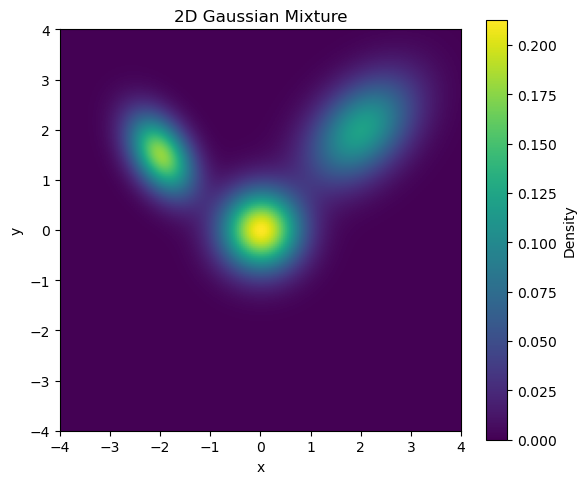

In [ ]:
import torch
import matplotlib.pyplot as plt

# Step 1: Create 2D grid
x_range = torch.linspace(-4, 4, 200)
y_range = torch.linspace(-4, 4, 200)
xx, yy = torch.meshgrid(x_range, y_range, indexing='xy')
x_test = torch.stack([xx.flatten(), yy.flatten()], dim=1)  # shape: [N, 2]

# Step 2: Define 2D Gaussian function
def gaussian_2d(x, mean, cov):
    """Compute 2D Gaussian PDF values for input x [N, 2]"""
    diff = x - mean  # shape: [N, 2]
    inv_cov = torch.linalg.inv(cov)
    exponent = -0.5 * torch.sum(diff @ inv_cov * diff, dim = 1)
    norm_const = 1.0 / (2 * torch.pi * torch.sqrt(torch.linalg.det(cov)))
    return norm_const * torch.exp(exponent)

# Step 3: Define mixture components
means = [
    torch.tensor([0.0, 0.0]),
    torch.tensor([2.0, 2.0]),
    torch.tensor([-2.0, 1.5])
]

covs = [
    torch.eye(2) * 0.3,
    torch.tensor([[0.5, 0.2], [0.2, 0.5]]),
    torch.tensor([[0.2, -0.1], [-0.1, 0.3]])
]

weights = [0.4, 0.35, 0.25]  # must sum to 1

# Step 4: Evaluate Gaussian Mixture Model
gm_vals = sum(
    w * gaussian_2d(x_test, mu, cov)
    for w, mu, cov in zip(weights, means, covs)
)

# Step 5: Plot
plt.figure(figsize=(6, 5))
plt.imshow(
    gm_vals.reshape(xx.shape),
    extent=[-4, 4, -4, 4],
    origin='lower',
    cmap='viridis'
)
plt.colorbar(label="Density")
plt.title("2D Gaussian Mixture")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()


In [75]:
def vortex(x0, y0, r):
	return np.arcsinh(np.sqrt((x - x0)**2 + (y - y0)**2 + r**2))

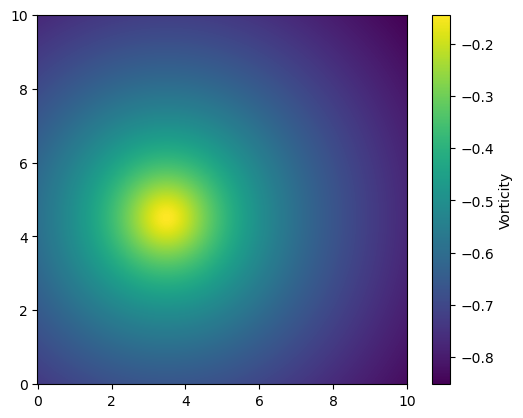

In [74]:
vort(3.5, 4.5, 0.5) * 0.3

plt.imshow(vortex(3.5, 4.5, 0.5) * 0.3, extent = extent, origin = 'lower')
plt.colorbar(label='Vorticity')  # You can customize the label

In [13]:
x_test.shape
y_test_dict["convergence"].shape

torch.Size([400, 2])

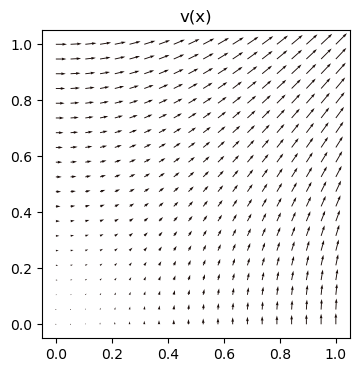

In [16]:
visualise_v_quiver(
    y_test_dict["convergence"],
    x_test,
)

# Visualise a scalar field and the corresponding curl

In [ ]:
# Make a scalar field
elevation = x_test[:, 0] * x_test[:, 1]



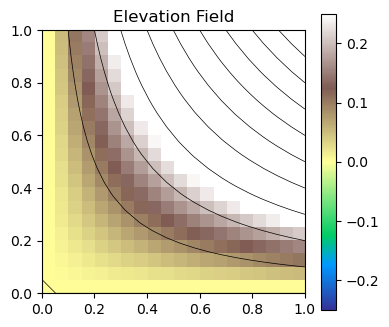

In [20]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch

def visualise_scalar_field(scalar_field, 
                           x, 
                           title_string = "Elevation Field", 
                           color_abs_max = None, 
                           cmap = "terrain", 
                           show_contours = True):
    """
    Visualizes a 2D scalar field (e.g., elevation) on a square grid using imshow and optional contours.

    Args:
        scalar_field (torch.Tensor): Shape (N_long,), flattened scalar values.
        x (torch.Tensor): Shape (N_long, 2), flattened 2D coordinates.
        title_string (str): Title of the plot.
        color_abs_max (float, optional): If given, sets symmetric color normalization.
        cmap (str): Colormap to use. Default is "terrain".
        show_contours (bool): Whether to show contour lines.
    """
    scalar_field = scalar_field.cpu().detach()
    x = x.cpu().detach()

    # Infer side length of square grid
    N_long = scalar_field.shape[0]
    N_side = int(torch.sqrt(torch.tensor(N_long)))

    # Reshape coordinates and scalar field
    X = x[:, 0].reshape(N_side, N_side)
    Y = x[:, 1].reshape(N_side, N_side)
    Z = scalar_field.reshape(N_side, N_side)

    fig, ax = plt.subplots(1, 1, figsize=(4, 4))

    if color_abs_max is not None:
        norm = mcolors.TwoSlopeNorm(vmin=-color_abs_max, vcenter=0, vmax=color_abs_max)
    else:
        norm = None

    img = ax.imshow(Z.numpy(), origin='lower',
                    extent=[X.min(), X.max(), Y.min(), Y.max()],
                    cmap=cmap, norm=norm)

    if show_contours:
        ax.contour(X.numpy(), Y.numpy(), Z.numpy(), levels=10, colors='k', linewidths=0.5)

    fig.colorbar(img, ax=ax, shrink=0.8)
    ax.set_aspect('equal')
    ax.set_title(title_string)
    plt.tight_layout()
    plt.show()

visualise_scalar_field(
    elevation, 
    x_test, 
    title_string = "Elevation Field", 
    color_abs_max = 0.25, 
    cmap = "terrain", 
    show_contours = True
)

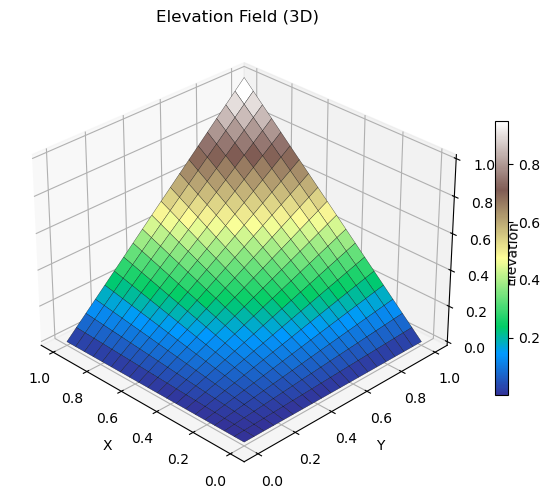

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (required for 3D)
import torch

def visualise_scalar_field_3d(scalar_field, x, 
                              title_string="Elevation Field (3D)", 
                              cmap="terrain"):
    """
    Visualizes a 2D scalar field (e.g., elevation) on a square grid using a 3D surface plot.

    Args:
        scalar_field (torch.Tensor): Shape (N_long,), flattened scalar values.
        x (torch.Tensor): Shape (N_long, 2), flattened 2D coordinates.
        title_string (str): Title of the plot.
        cmap (str): Colormap to use. Default is "terrain".
    """
    scalar_field = scalar_field.cpu().detach()
    x = x.cpu().detach()

    # Infer square grid shape
    N_long = scalar_field.shape[0]
    N_side = int(torch.sqrt(torch.tensor(N_long)))

    # Reshape
    X = x[:, 0].reshape(N_side, N_side).numpy()
    Y = x[:, 1].reshape(N_side, N_side).numpy()
    Z = scalar_field.reshape(N_side, N_side).numpy()

    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.invert_yaxis()

    surf = ax.plot_surface(X, Y, Z, cmap=cmap, edgecolor='k', linewidth=0.2, antialiased=True)
    
    fig.colorbar(surf, ax=ax, shrink=0.6)
    ax.set_title(title_string)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Elevation")
    ax.view_init(elev=30, azim=135)  # Adjust for a nice angle
    plt.tight_layout()
    plt.show()

visualise_scalar_field_3d(
    elevation, 
    x_test, 
    title_string = "Elevation Field (3D)", 
    cmap = "terrain"
)

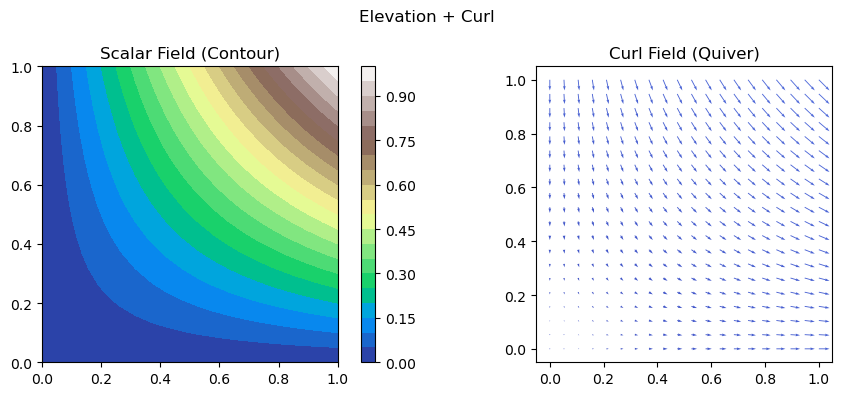

In [30]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualise_scalar_and_curl(scalar_field, x, title="Scalar + Curl", color_abs_max=1.0):
    """
    Plots a 2D scalar field as a contour map, and its curl as a vector field.

    Args:
        scalar_field (torch.Tensor): Shape (N_long,), 2D flattened scalar field.
        x (torch.Tensor): Shape (N_long, 2), flattened grid coordinates.
        title (str): Super title of the figure.
        color_abs_max (float): Max magnitude for curl color scaling.
    """
    scalar_field = scalar_field.cpu().detach()
    x = x.cpu().detach()

    N_long = scalar_field.shape[0]
    N_side = int(torch.sqrt(torch.tensor(N_long)))

    X = x[:, 0].reshape(N_side, N_side).numpy()
    Y = x[:, 1].reshape(N_side, N_side).numpy()
    Z = scalar_field.reshape(N_side, N_side).numpy()

    # Compute curl from scalar field (interpreted as a height map f(x, y))
    # Curl of scalar f is (∂f/∂y, -∂f/∂x)
    df_dy, df_dx = np.gradient(Z, edge_order=2)  # Z[y, x], so axis 0 is y
    curl_x = df_dy  # v component
    curl_y = -df_dx # u component

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(title)

    # Contour plot
    cp = axs[0].contourf(X, Y, Z, cmap="terrain", levels=20)
    axs[0].set_title("Scalar Field (Contour)")
    fig.colorbar(cp, ax=axs[0])
    axs[0].set_aspect(1)
    # axs[0].invert_yaxis()

    # Quiver plot of curl
    axs[1].quiver(X, Y, curl_x, curl_y, 
                  np.sqrt(curl_x**2 + curl_y**2), 
                  cmap='coolwarm', clim=(0, color_abs_max))
    axs[1].set_title("Curl Field (Quiver)")
    axs[1].set_aspect(1)
    # axs[1].invert_yaxis()

    plt.tight_layout()
    plt.show()

visualise_scalar_and_curl(
    elevation, 
    x_test, 
    title = "Elevation + Curl", 
    color_abs_max = 1.0
)

# The curl flows along the contour lines

In [58]:
extent

(-0.005, 10.005, -0.005, 10.005)

In [27]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualise_scalar_and_curl(scalar_field, x, title="Scalar + Curl", color_abs_max=1.0):
    """
    Plots a 2D scalar field as a contour map, and its curl as a vector field.

    Args:
        scalar_field (torch.Tensor): Shape (N_long,), 2D flattened scalar field.
        x (torch.Tensor): Shape (N_long, 2), flattened grid coordinates.
        title (str): Super title of the figure.
        color_abs_max (float): Max magnitude for curl color scaling.
    """
    scalar_field = scalar_field.cpu().detach()
    x = x.cpu().detach()

    N_long = scalar_field.shape[0]
    N_side = int(torch.sqrt(torch.tensor(N_long)))

    X = x[:, 0].reshape(N_side, N_side).numpy()
    Y = x[:, 1].reshape(N_side, N_side).numpy()
    Z = scalar_field.reshape(N_side, N_side).numpy()

    # Compute curl from scalar field (interpreted as a height map f(x, y))
    # Curl of scalar f is (∂f/∂y, -∂f/∂x)
    df_dy, df_dx = np.gradient(Z, edge_order=2)  # Z[y, x], so axis 0 is y
    curl_x = df_dy  # v component
    curl_y = -df_dx # u component

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(title)

    # Contour plot
    cp = axs[0].contourf(X, Y, Z, cmap="terrain", levels=20)
    axs[0].set_title("Scalar Field (Contour)")
    fig.colorbar(cp, ax=axs[0])
    axs[0].set_aspect(1)
    axs[0].invert_yaxis()

    # Quiver plot of curl
    axs[1].quiver(X, Y, curl_x, curl_y, 
                  np.sqrt(curl_x**2 + curl_y**2), 
                  cmap='coolwarm', clim=(0, color_abs_max))
    axs[1].set_title("Curl Field (Quiver)")
    axs[1].set_aspect(1)
    axs[1].invert_yaxis()

    plt.tight_layout()
    plt.show()


visualise_scalar_and_curl(
    y_test_dict["convergence"], 
    x_test, 
    title = "Convergence + Curl", 
    color_abs_max = 1.0)

RuntimeError: shape '[20, 20]' is invalid for input of size 800